In [1]:
from fastai.vision.all import *


In [2]:
data_dir = Path("dk_bugs")

In [3]:
files = get_image_files(data_dir)
len(files)

845

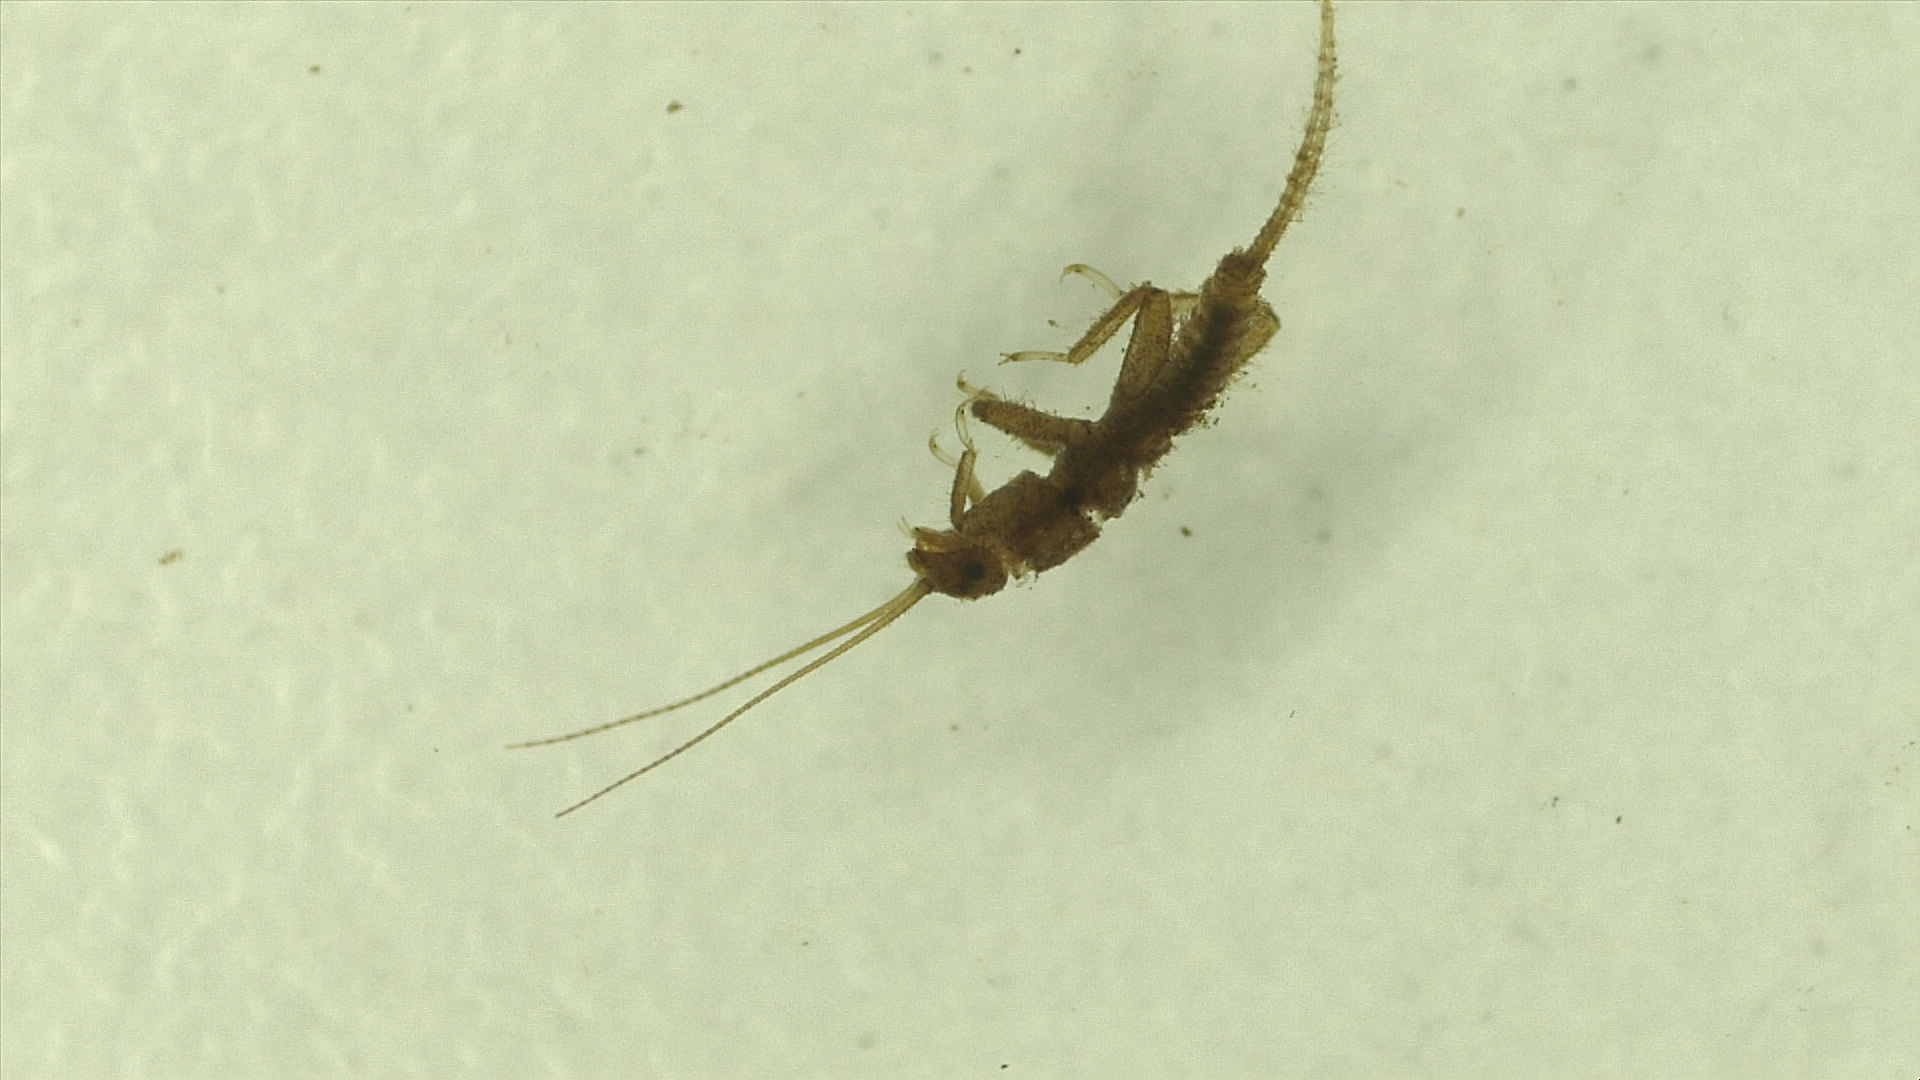

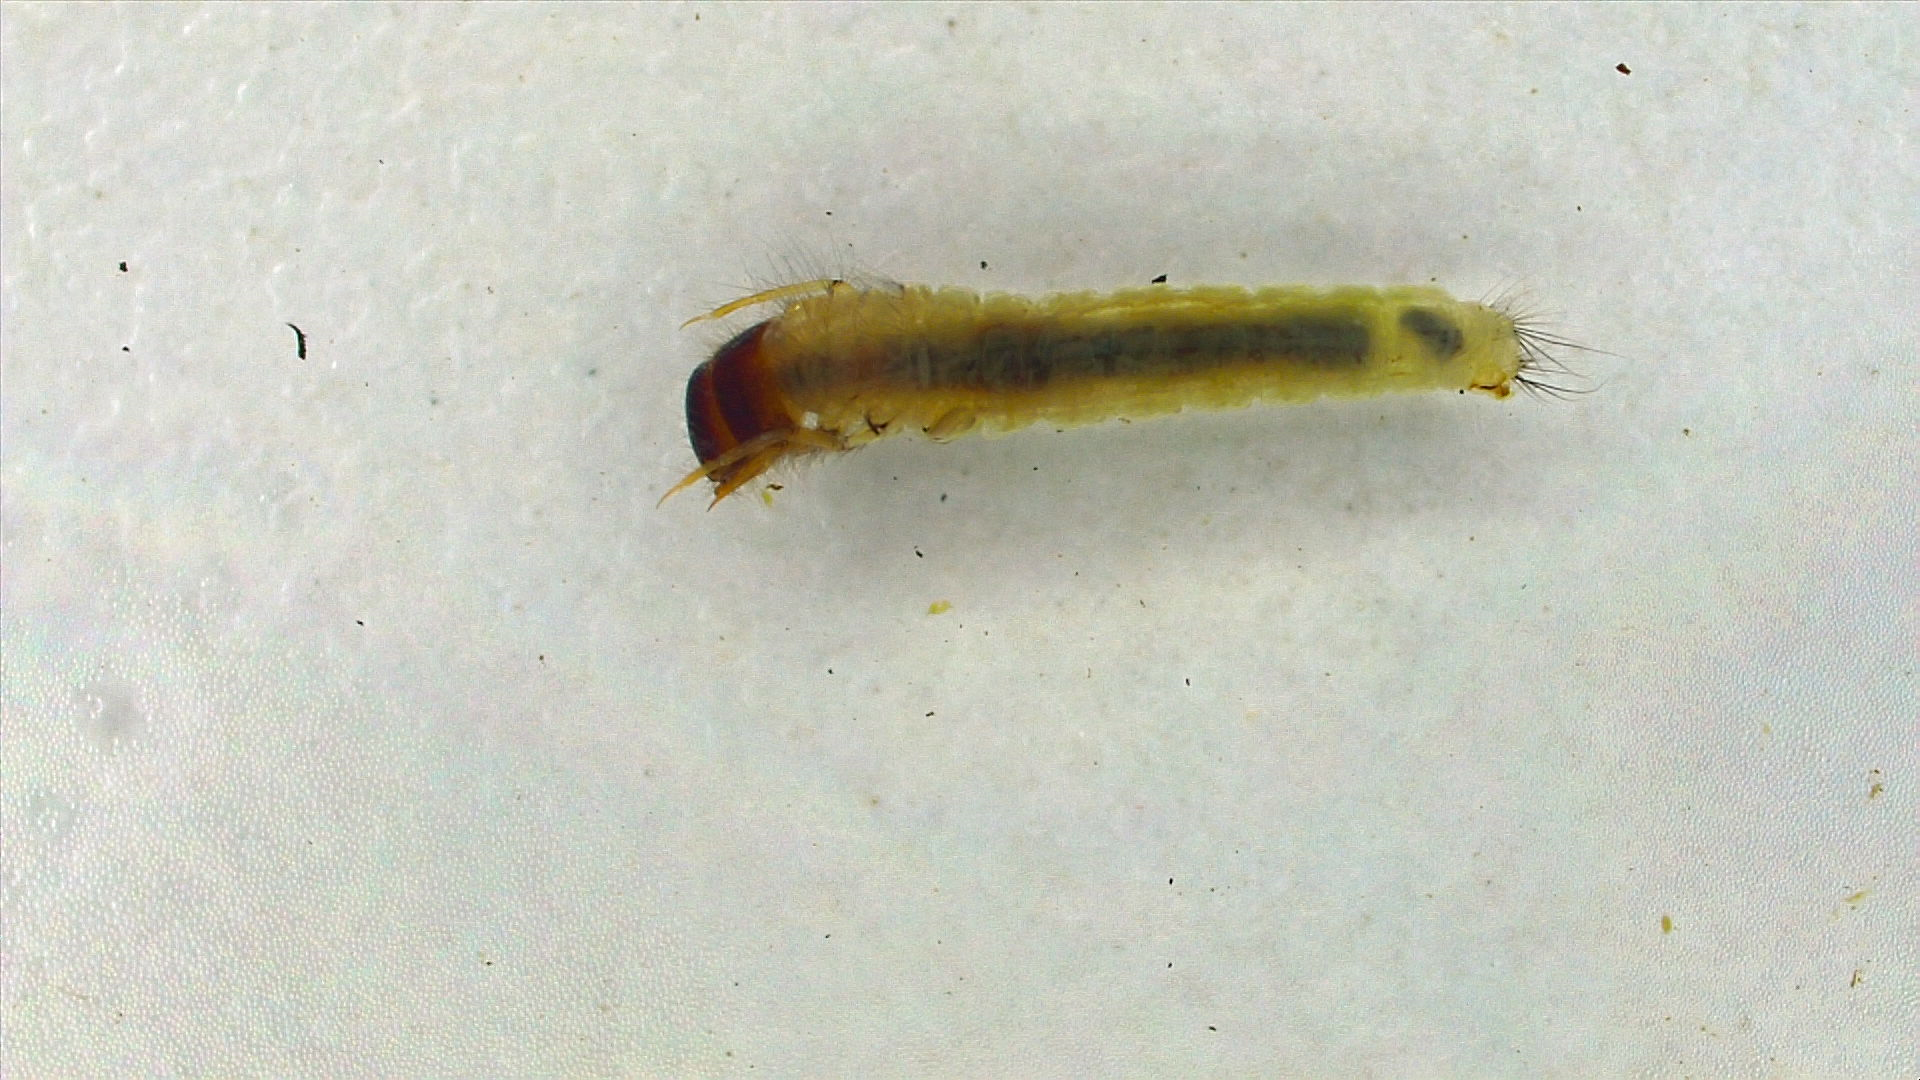

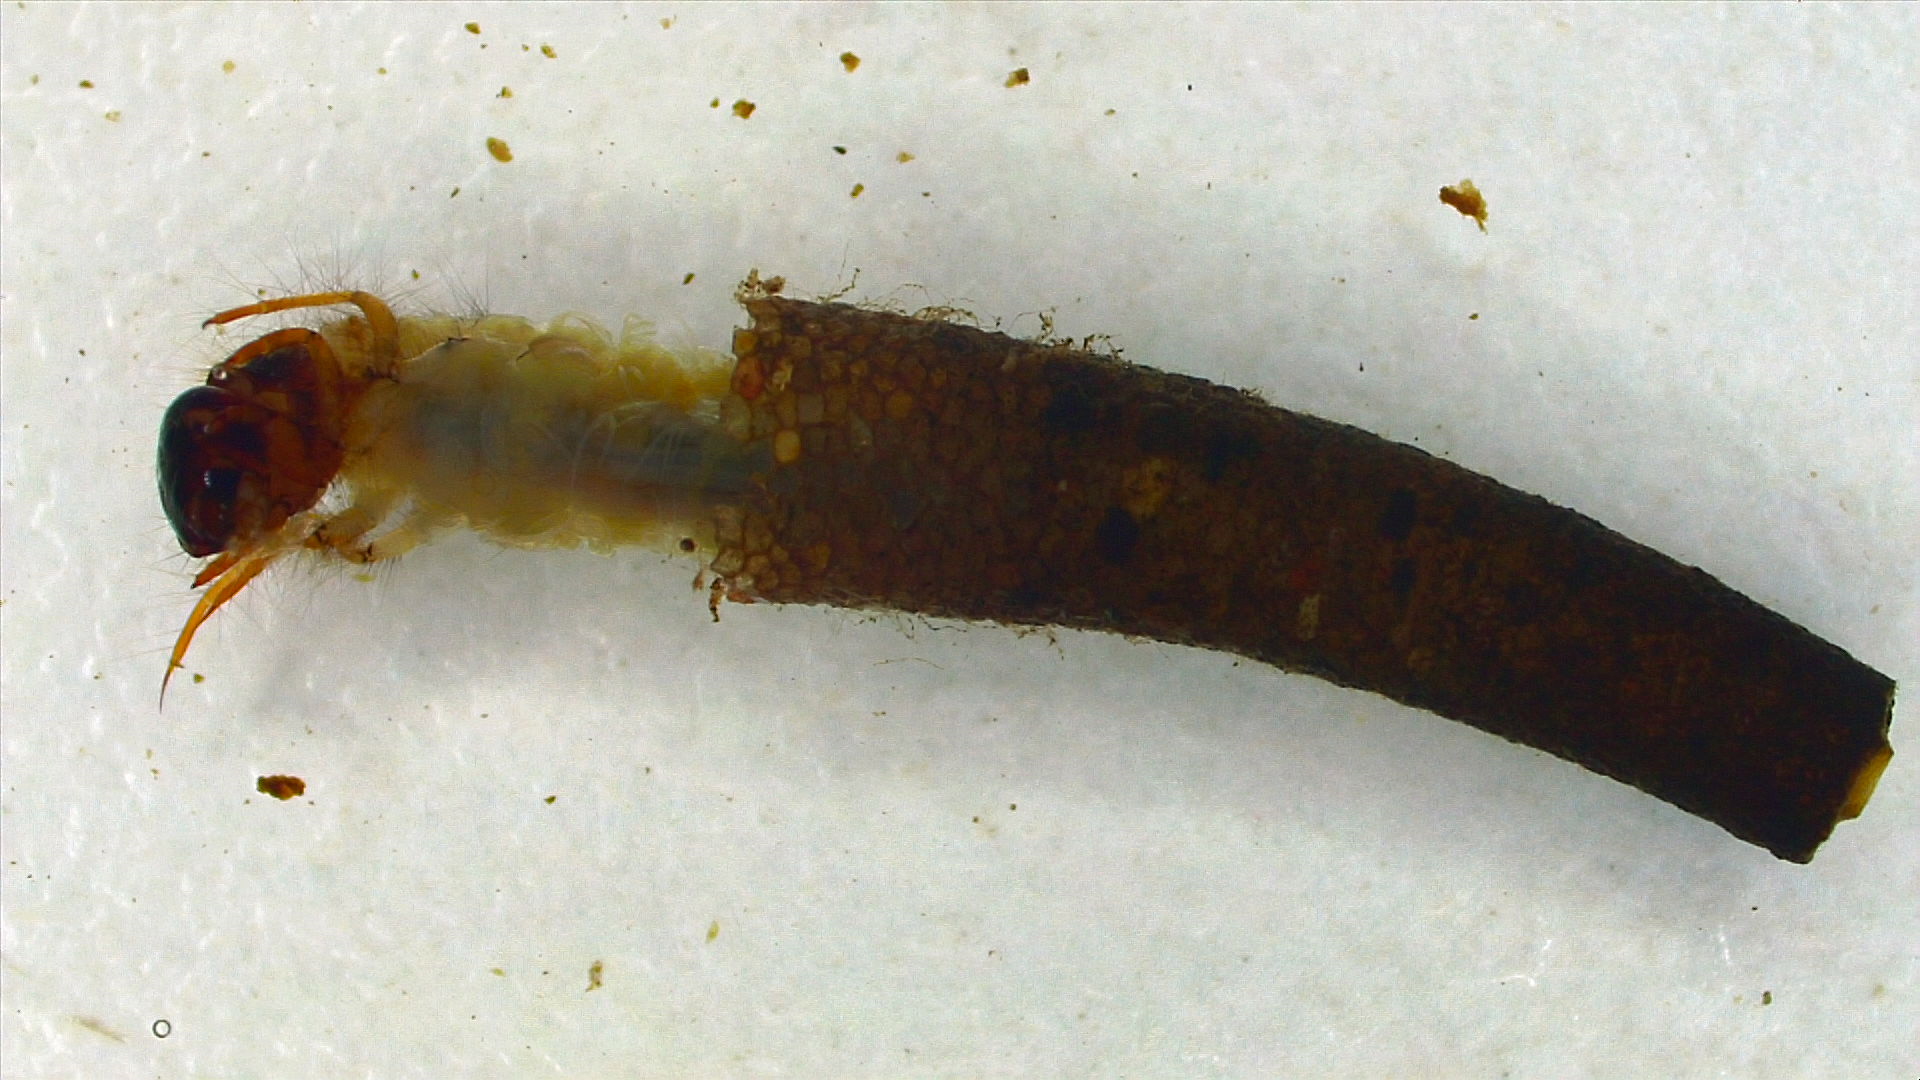

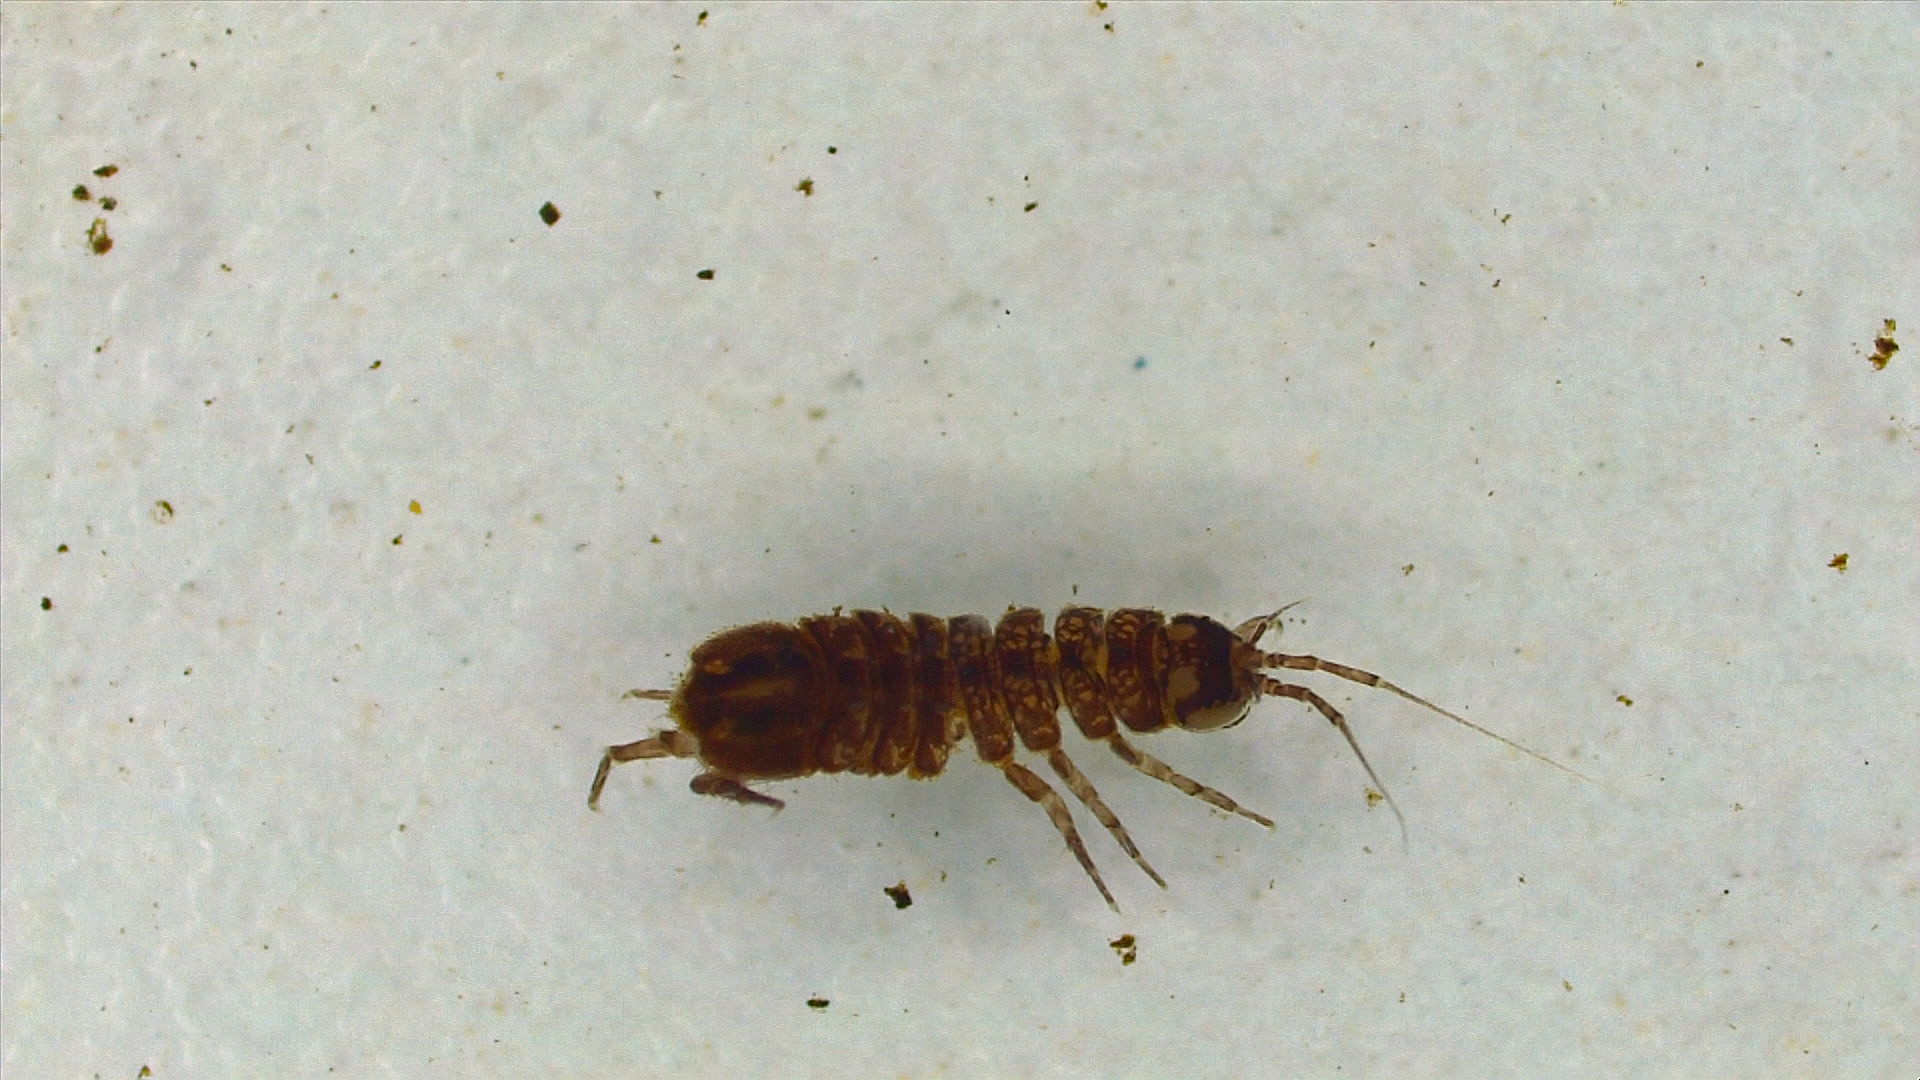

In [4]:
from IPython.display import Image
from IPython.display import display

random_imgs = random.choices(files, k=4)

imgs_list = [Image(i, width = 140) for i in random_imgs] 

display(*imgs_list)

In [5]:
dataloaders = ImageDataLoaders.from_folder(path=data_dir, 
                                           valid_pct=0.2,
                                           bs=64,
                                           item_tfms=Resize(224*3), 
                                           batch_tfms=aug_transforms(mult=2, size=224, min_scale=0.85, flip_vert=True))

In [6]:
dataloaders.vocab

['asellus_aquaticus', 'baetis_rhodani', 'clausiliidae_indet', 'elmis_aenea', 'erpobdella_octoculato', 'gammarus', 'gastropoda_indet', 'glossiphonia_complanata', 'hydracorina_indet', 'hydropsyche_sp', 'leuctra_sp', 'limnius_volckmari', 'lymnaea_stagnalis', 'nemoura_sp', 'nepa_cinerea', 'pediciinae_indet_1', 'pediciinae_indet_2', 'ptychoptera_sp', 'sericostomatidae_sp', 'simuliidae_sp', 'sphaerium_corneum']

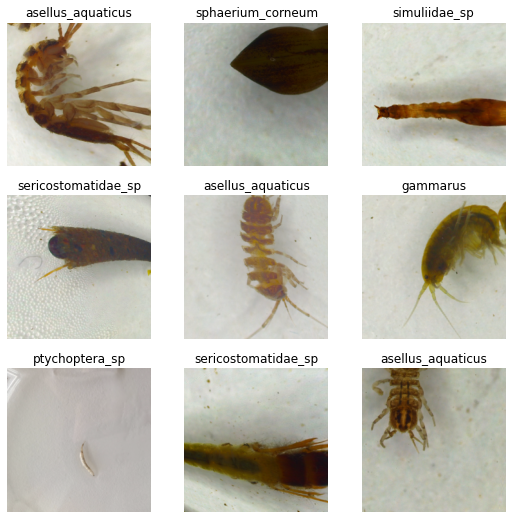

In [8]:
dataloaders.show_batch()

In [9]:
learn = cnn_learner(dataloaders, resnet34, cbs=MixUp(), metrics=error_rate, loss_func=LabelSmoothingCrossEntropy())

In [10]:
#appear to break training when using mixup
#learn.freeze()
#learn.lr_find()

In [11]:
learn.fine_tune(10, base_lr=0.001, freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,4.308893,2.644173,0.710059,00:09
1,3.634044,1.414715,0.230769,00:08


epoch,train_loss,valid_loss,error_rate,time
0,2.532324,1.336840,0.201183,00:09
1,2.434294,1.190251,0.189349,00:09
2,2.341753,1.094220,0.118343,00:08
3,2.258064,1.013548,0.106509,00:09
4,2.182255,0.964212,0.088757,00:08
5,2.098636,0.935667,0.082840,00:08
6,2.053396,0.916386,0.082840,00:08
7,2.012512,0.901760,0.071006,00:09
8,1.977245,0.893250,0.059172,00:09
9,1.957987,0.895494,0.065089,00:09


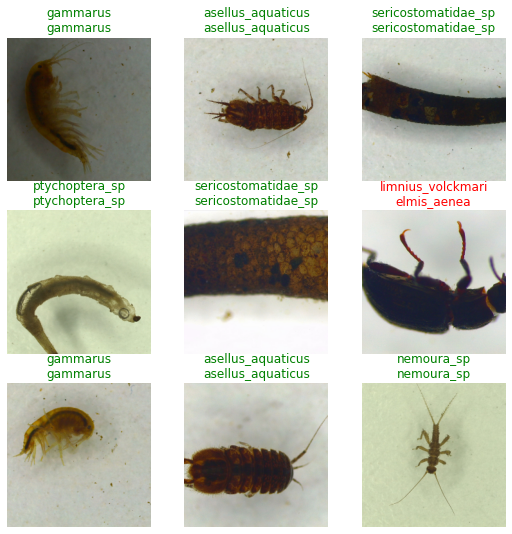

In [14]:
learn.show_results()


In [15]:
learn.export()